In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# Function to read text from a file 
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

filename = "/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
# load the descriptions of images
doc = load_doc(filename)
#print discriptions of a specific image
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


Create a Dictionary that contains the captions of all images, where the image ID is the key and the Image captions are values`

In [4]:
def load_descriptions(doc):
	descriptions  = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create a list if needed
		if image_id not in descriptions:
			descriptions [image_id] = list()
		# save  captions of the images
		descriptions[image_id].append(image_desc)
	return descriptions 

# get the descriptions of the images
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions[ '1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

Clean the Captions of the images by 
1. convert text to lower case
2. Remove Punctuation 
3. Remove numbers
4. Remove words that contains 1 letter

In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			# remove punctuation from each word
			desc = [w.translate(table) for w in desc]
			# remove words that contain 1 letter
			desc = [word for word in desc if len(word)>1]
			# remove words that have non alohapitic chars
			desc = [word for word in desc if word.isalpha()]
			# join the sentence back
			desc_list[i] =  ' '.join(desc)

# clean the captions
clean_descriptions(descriptions)

In [8]:
#Captions after cleaning
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [9]:
# Create a vocabulary of all the unique words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [10]:
# save captions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [11]:
# get the names of the training set images 
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset
filename = '/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [12]:
images = '/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [13]:
train_images_file = '/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the training images names
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images: # if the image belongs to training set
        train_img.append(i)

In [14]:
test_images_file = '/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img:
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) 

In [15]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# Add start tag before the descriptions and end tag after the descriptions
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [16]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the InceptionResNetV2  model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from InceptionResNetV2 model
    x = preprocess_input(x)
    return x

In [17]:
# Load the InceptionResNetV2 model
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

model = InceptionResNetV2(weights='imagenet')

225214464/225209952 [==============================] - 67s 0us/step


In [18]:
# Create a new model, by removing the last layer (output Fullyconnected layer) from the InceptionResNetV2
model_new = Model(model.input, model.layers[-2].output)

In [19]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [21]:
# convert all the train images into a vector of size (2048, )
# Execute only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [22]:
# Save the train features to file
import _pickle as cPickle

with open("/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_train, encoded_pickle)

In [24]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [25]:
# Save the test features to file
with open("/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_test, encoded_pickle)

In [27]:
train_features = load(open("/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [28]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [29]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [32]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most common words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum word length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # get the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence to reach the max length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

Bert Embeddings Trial to Use to encode the captions of the images instead of glove or fast. 

In [34]:
from flair.embeddings import BertEmbeddings


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [35]:
bert_embeddings = BertEmbeddings('bert-base-uncased')

In [51]:
import torch
from flair.data import Sentence
embedding_matrix = np.zeros((30000, 3072))

mylist = []
for key, desc_list in descriptions.items():
    for desc in desc_list:
        mysent = Sentence(desc, use_tokenizer=True)
        bert_embeddings.embed(mysent)
        i=0
        if(i < 29999):
            for token in mysent:
    #             mylist.append(torch.cat([token.embedding.unsqueeze(0) for token in mysent], dim=0))
    #              mylist.append(token, token.embedding)
                embedding_matrix[i] = token.embedding
                i+=1
                print(token.embedding)
                print("matrix")
                print(embedding_matrix)
        else:
            break

tensor([-0.6030, -0.4226,  0.3492,  ..., -1.2533,  0.6644, -1.1497])
matrix
[[-0.60299909 -0.42263743  0.34921145 ... -1.25325859  0.66435444
  -1.14966357]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.0473,  0.0653, -0.2322,  ..., -0.2797,  0.6151,  0.1849])
matrix
[[-0.60299909 -0.42263743  0.34921145 ... -1.25325859  0.66435444
  -1.14966357]
 [ 0.04726297  0.06525963 -0.23222664 ... -0.27967268  0.61506253
   0.18487427]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.     

tensor([-0.4197, -0.1319,  0.4104,  ..., -0.1281,  0.7795, -0.8929])
matrix
[[-0.41966647 -0.1319015   0.4104391  ... -0.12810865  0.77950257
  -0.89289033]
 [-0.891617   -1.02626824  0.2120931  ... -0.86273652  1.08867693
  -1.01428819]
 [-0.54751229 -0.29839361 -0.20159678 ... -0.03066175  0.5742963
   0.18033309]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([-0.6896, -0.6276,  0.6203,  ..., -0.1052,  0.9936, -0.7551])
matrix
[[-0.41966647 -0.1319015   0.4104391  ... -0.12810865  0.77950257
  -0.89289033]
 [-0.68958062 -0.62756425  0.62033969 ... -0.10522273  0.99362165
  -0.75509238]
 [-0.54751229 -0.29839361 -0.20159678 ... -0.03066175  0.5742963
   0.18033309]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   

tensor([ 0.2612, -0.0987, -0.2554,  ..., -0.3456, -0.2285, -0.8425])
matrix
[[ 0.26119277 -0.0987374  -0.25540179 ... -0.34561673 -0.22850725
  -0.84245819]
 [-0.84724313 -1.00180995  0.31740215 ... -1.3594141   1.51024699
  -1.13413012]
 [-0.70366359  0.13858092 -0.25884852 ... -0.37591082  0.70933282
   0.01046523]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([-0.0868, -0.4377, -0.4865,  ..., -0.6012,  0.4344, -0.5590])
matrix
[[ 0.26119277 -0.0987374  -0.25540179 ... -0.34561673 -0.22850725
  -0.84245819]
 [-0.08680185 -0.43768057 -0.48649463 ... -0.60118186  0.43436161
  -0.55900007]
 [-0.70366359  0.13858092 -0.25884852 ... -0.37591082  0.70933282
   0.01046523]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([ 0.5903,  0.1710, -0.1734,  ..., -0.8400,  0.5166, -0.8579])
matrix
[[ 0.59026098  0.17095914 -0.17341098 ... -0.83995736  0.51655036
  -0.85790676]
 [ 0.47901332 -0.28542513 -0.44598663 ... -0.44170409  0.27226794
  -0.31230479]
 [-0.35302958  0.09418058 -0.27705458 ...  0.63284308  1.00243962
  -0.27116767]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.5479,  0.1007,  0.1348,  ..., -0.7545,  0.6714, -0.3974])
matrix
[[ 0.59026098  0.17095914 -0.17341098 ... -0.83995736  0.51655036
  -0.85790676]
 [ 0.54786265  0.10066879  0.13477656 ... -0.75447029  0.67135137
  -0.39735451]
 [-0.35302958  0.09418058 -0.27705458 ...  0.63284308  1.00243962
  -0.27116767]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([ 0.2138,  0.2719, -0.5514,  ..., -0.2146,  0.3702, -0.6955])
matrix
[[ 0.21375501  0.27185434 -0.5514273  ... -0.21460593  0.37024316
  -0.69550639]
 [ 1.2678349   0.63218653 -0.24224558 ... -1.06340182  0.07634681
  -0.00333926]
 [ 0.02805681  0.42140761  0.0499994  ... -0.77439505  0.1928203
  -0.77804112]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.7214,  0.4995,  0.1218,  ..., -0.8451, -0.1589,  0.4773])
matrix
[[ 0.21375501  0.27185434 -0.5514273  ... -0.21460593  0.37024316
  -0.69550639]
 [ 0.72141063  0.49952927  0.1218148  ... -0.84505314 -0.15885824
   0.47734955]
 [ 0.02805681  0.42140761  0.0499994  ... -0.77439505  0.1928203
  -0.77804112]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   

tensor([-0.3275, -0.1392,  0.4418,  ..., -0.9657,  0.9570, -1.0896])
matrix
[[-0.32751521 -0.13922366  0.44183606 ... -0.96568048  0.95697814
  -1.08962178]
 [-0.69055444 -0.50341278  0.73684818 ... -0.86275047  0.92576593
  -0.8310045 ]
 [-0.31889006  0.2297847   0.54020232 ... -0.93153715  0.77356356
  -0.88166094]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([-0.9675, -0.6424,  0.7793,  ..., -1.1739,  1.1704, -1.3005])
matrix
[[-0.32751521 -0.13922366  0.44183606 ... -0.96568048  0.95697814
  -1.08962178]
 [-0.96754509 -0.64238787  0.77932084 ... -1.173949    1.17036164
  -1.30052006]
 [-0.31889006  0.2297847   0.54020232 ... -0.93153715  0.77356356
  -0.88166094]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([-0.2166, -0.2971, -0.4039,  ..., -0.3861,  1.0210, -0.5294])
matrix
[[-0.21655145 -0.29710811 -0.40393725 ... -0.38612714  1.02096641
  -0.52938789]
 [-0.34990826 -1.0040884   0.05079276 ... -0.90818661  0.65039361
  -0.82577074]
 [-0.15481573 -0.58108312 -0.35028982 ... -0.26680806  0.39046064
   0.17805776]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([-0.1528, -0.3537, -0.0077,  ..., -0.8448,  1.0808,  0.1395])
matrix
[[-0.21655145 -0.29710811 -0.40393725 ... -0.38612714  1.02096641
  -0.52938789]
 [-0.15284722 -0.35373476 -0.00769632 ... -0.8447755   1.08081532
   0.13946418]
 [-0.15481573 -0.58108312 -0.35028982 ... -0.26680806  0.39046064
   0.17805776]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([-0.2329,  0.2934, -0.1945,  ..., -0.5219,  0.4659, -0.9388])
matrix
[[-0.23289868  0.29339236 -0.19447803 ... -0.52187395  0.46592447
  -0.93878806]
 [-0.10198232 -1.50375819  0.00437614 ... -0.82091045  0.56028706
  -1.09629357]
 [ 0.13869581 -0.08501235  0.19829583 ... -0.45873341  0.34284827
  -0.29189572]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.6112,  0.0512,  0.0886,  ..., -0.2323, -0.0557, -0.0464])
matrix
[[-0.23289868  0.29339236 -0.19447803 ... -0.52187395  0.46592447
  -0.93878806]
 [ 0.61124307  0.05124015  0.08857103 ... -0.2323291  -0.05574348
  -0.04640932]
 [ 0.13869581 -0.08501235  0.19829583 ... -0.45873341  0.34284827
  -0.29189572]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([-0.0020, -0.0225, -0.3417,  ..., -0.5205,  0.5122, -0.5344])
matrix
[[-0.00202774 -0.0225192  -0.341737   ... -0.5204559   0.51215887
  -0.53439492]
 [ 0.4482725  -0.25438389 -0.05043558 ... -0.44963768  0.21765395
  -0.21768872]
 [-0.34906456 -0.11461698  0.21078402 ...  0.3141087   1.08763194
   0.13028215]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.4933,  0.1537, -0.2337,  ..., -0.3206, -0.4267, -0.2593])
matrix
[[-0.00202774 -0.0225192  -0.341737   ... -0.5204559   0.51215887
  -0.53439492]
 [ 0.49329069  0.15368351 -0.23370957 ... -0.32059133 -0.42665675
  -0.2592839 ]
 [-0.34906456 -0.11461698  0.21078402 ...  0.3141087   1.08763194
   0.13028215]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([-0.3219, -0.0322, -0.3365,  ..., -1.0486,  0.2621, -1.0098])
matrix
[[-0.3218956  -0.03219897 -0.33647951 ... -1.04861379  0.26212227
  -1.00983489]
 [-0.22803126 -0.16607606  0.2399534  ... -1.1513226   0.65032512
  -0.78577942]
 [ 0.4940173  -0.20675847  0.01770986 ... -0.71909863 -0.07106788
   0.21277896]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([-0.3011, -0.0706, -0.2901,  ..., -0.9401,  0.0315, -1.1457])
matrix
[[-0.3218956  -0.03219897 -0.33647951 ... -1.04861379  0.26212227
  -1.00983489]
 [-0.30108345 -0.07056373 -0.29012722 ... -0.94008458  0.03149485
  -1.14571583]
 [ 0.4940173  -0.20675847  0.01770986 ... -0.71909863 -0.07106788
   0.21277896]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
 

tensor([-0.2663, -0.2889, -0.5895,  ..., -0.7702,  1.1511, -0.2308])
matrix
[[-0.26633543 -0.2889196  -0.58951259 ... -0.77021158  1.1510824
  -0.23077303]
 [-0.34472263 -0.09046844 -1.14741361 ...  0.95538259  0.25577268
   0.14189959]
 [-0.14195478  0.12263311 -1.1730032  ... -0.40774453  0.43355197
   0.69553989]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
tensor([ 0.0226,  0.2652, -0.4798,  ..., -0.0270,  0.2719, -0.1372])
matrix
[[-0.26633543 -0.2889196  -0.58951259 ... -0.77021158  1.1510824
  -0.23077303]
 [ 0.02259359  0.26522422 -0.47981659 ... -0.0270138   0.27193868
  -0.13715683]
 [-0.14195478  0.12263311 -1.1730032  ... -0.40774453  0.43355197
   0.69553989]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   

KeyboardInterrupt: 

In [52]:
import torch
from flair.data import Sentence
embedding_matrix = np.zeros((30000, 3072))

mylist = []
for key, desc_list in descriptions.items():
    for desc in desc_list:
        mysent = Sentence(desc, use_tokenizer=True)
        bert_embeddings.embed(mysent)
        i=0
        if(i < 29999):
            for token in mysent:
    #             mylist.append(torch.cat([token.embedding.unsqueeze(0) for token in mysent], dim=0))
    #              mylist.append(token, token.embedding)
                embedding_matrix[i] = token.embedding
                i+=1
        else:
            break

In [53]:
embedding_matrix.shape

(30000, 3072)

In [54]:
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,)) #Text
se1 = Embedding(30000, 3072, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 3072)     92160000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [56]:
model.layers[2]

In [57]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [58]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [131]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
print(steps)

2000


In [61]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 2630s 1s/step - loss: 4.3798
Epoch 1/1
2000/2000 [==============================] - 2086s 1s/step - loss: 4.0173
Epoch 1/1
2000/2000 [==============================] - 2215s 1s/step - loss: 3.8800
Epoch 1/1
2000/2000 [==============================] - 2377s 1s/step - loss: 3.7844
Epoch 1/1
2000/2000 [==============================] - 2844s 1s/step - loss: 3.7077
Epoch 1/1
2000/2000 [==============================] - 2470s 1s/step - loss: 3.6444
Epoch 1/1
2000/2000 [==============================] - 2052s 1s/step - loss: 3.5941
Epoch 1/1
2000/2000 [==============================] - 2652s 1s/step - loss: 3.5485
Epoch 1/1
2000/2000 [==============================] - 2593s 1s/step - loss: 3.5083
Epoch 1/1
2000/2000 [==============================] - 2265s 1s/step - loss: 3.4733


In [63]:
model.load_weights('/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/model_weights/model_9.h5')

In [64]:
images = '/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'

In [65]:
with open("/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [66]:
def predict_captions(image):
    start_word = ['startseq']
    while True:
        par_caps = [wordtoix[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_length, padding='post')
        e = encoding_test[image[len(images):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = ixtoword[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred ==  'endseq' or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

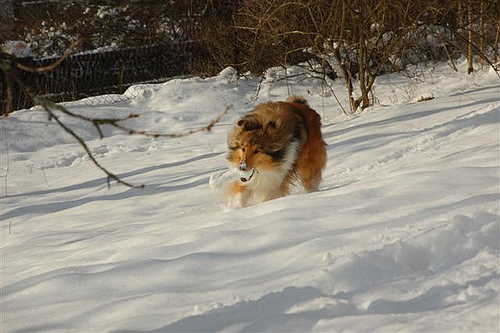

In [123]:
test_image = test_img[12]
Image.open(test_image)

In [124]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: dog runs through the snow


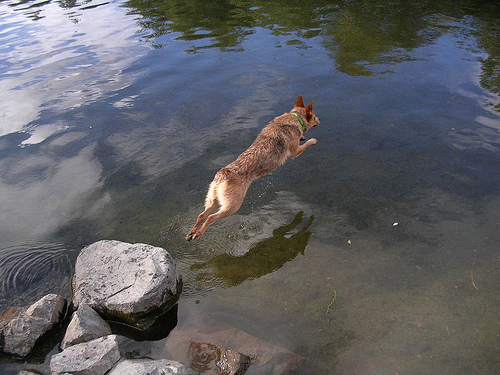

In [119]:
test_image = test_img[10]
Image.open(test_image)

In [120]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: dog is running through the water


In [133]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,use_multiprocessing=True)
#     model.save('/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/model_weights/model_' + str(i) + '.h5')

In [199]:
model.load_weights('/home/nesma/SemesterII/LanguageAndImageProcessing/HW5/model_weights/model_19.h5')

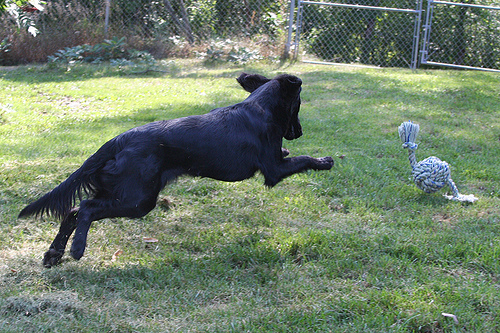

In [200]:
test_image = test_img[5]
Image.open(test_image)

In [201]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: two dogs play in the grass


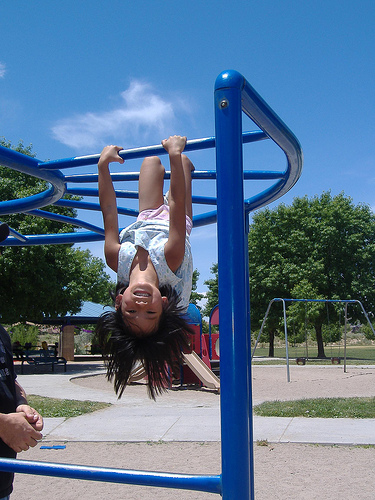

In [206]:
test_image = test_img[952]
Image.open(test_image)

In [207]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: two girls are playing on the jungle gym
